# Wheat Seeds Data Set

Source: https://archive.ics.uci.edu/ml/datasets/seeds

In [1]:
%config InlineBackend.figure_format = 'retina'
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import neighbors
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from functools import partial
from matplotlib.colors import ListedColormap
from sklearn import tree

## Background

### Data Set Information:

> The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.


### Attribute Information:

> To construct the data, seven geometric parameters of wheat kernels were measured:
1. area A,
2. perimeter P,
3. compactness C = 4 * PI * A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.

> All of these parameters were real-valued continuous.



## Load the modified Seeds dataset

In [2]:
# Seeds dataset
X_and_Y = np.loadtxt('seeds.csv', delimiter='\t').astype(np.float32) # Load data from file.

np.random.seed(1)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==1] = -1   
Y_shuffled[Y_shuffled==3] = -1
Y_shuffled[Y_shuffled==2] = 1                     

print(X_shuffled.shape)      # (210, 7)
print(Y_shuffled.shape)      # (210,)
print(X_and_Y[0])
# The result should be:
# [15.11   14.54    0.8986  5.579   3.462   3.128   5.18    1.    ]

(210, 7)
(210,)
[15.11   14.54    0.8986  5.579   3.462   3.128   5.18   -1.    ]


In [3]:
# Data Set Sizes
a = 0.8 * len(X_shuffled)
b = 0.2 * len(X_shuffled)
print(a, b, a+b)

168.0 42.0 210.0


## Visualization

In [4]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    
    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        print(temp)
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        print(x0_min, x0_max)
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

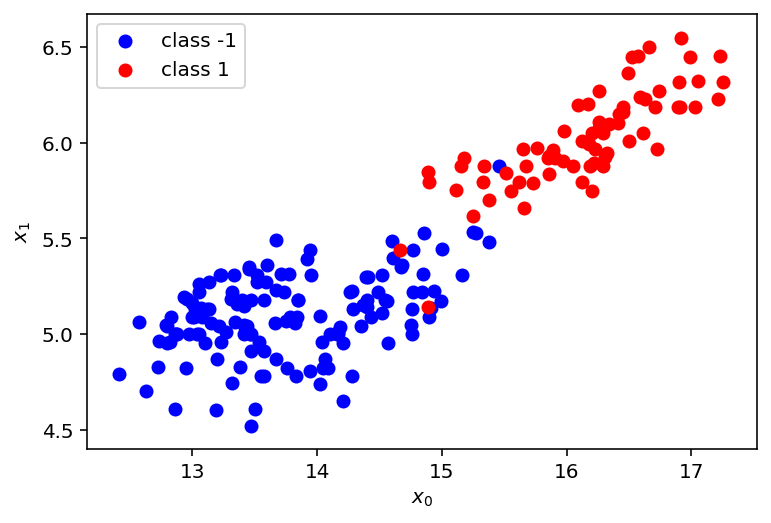

In [5]:
# visualization raw data set
vis(X_shuffled[:,[1,6]], Y_shuffled)

## Classifier #1: Linear SVM with Scikit-Learn

In [6]:
# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)  # Hint: Use classifier.predict()
    e = accuracy_score(Y, Y_pred)   # Hint: Use accuracy_score().
    return e

In [23]:
def linear_svm(X, Y, X_test=None, Y_test=None):
    C_list = [0.1, 1, 10, 100, 1000]
    opt_e_training = 1.0   # Optimal training error.
    opt_classifier = None  # Optimal classifier.
    opt_C          = None  # Optimal C.

    for C in C_list:
        # Create a linear SVM classifier.
        # Hints: You can use svm.LinearSVC()
        #        Besides, we use Hinge loss and L2 penalty for weights.
        #        The max iterations should be set to 10000.
        #        The regularization parameter should be set as C.
        #        The other arguments of svm.LinearSVC() are set as default values.
        classifier = svm.LinearSVC(penalty='l2', loss='hinge', max_iter=10000, C=C);

        # Use the classifier to fit the training set (use X_train, Y_train).
        # Hint: You can use classifier.fit().
        ######### To be filled. #########
        classifier.fit(X, Y)

        # Obtain the weights and bias from the linear SVM classifier.
        W = classifier.coef_[0]
        b = classifier.intercept_[0]

        # Show decision boundary, training error and test error.
        print('C = {}'.format(C))
        print('Decision boundary: {:.3f}x_0+{:.3f}x_1+{:.3f}=0'.format(W[0],W[1],b))
        vis(X, Y, W, b)
        e_training = calc_error(X, Y, classifier)
        print('Training error: {}'.format(e_training))
        print('\n\n\n')

        # Judge if it is the optimal one.
        if e_training < opt_e_training:
            opt_e_training = e_training
            opt_classifier = classifier
            opt_C = C
        
        if X_test is not None:
            print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))

## Classifier #2: KNN with Scikit-Learn

In [8]:
# Draw heatmaps for result of grid search.
def draw_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='k')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [9]:
def knn_gridsearch(X, Y):
    # Perform grid search for best number of nearest neighbors.

    # 1. Create a k-NN classifier.
    estimator = neighbors.KNeighborsClassifier()

    # 2. Create a grid searcher with 5-fold cross-validation.
    k_list = [1, 2, 3]
    param_grid = {'n_neighbors': k_list}
    grid_search = GridSearchCV(estimator, param_grid, cv=5)

    # 3. Use the grid searcher to fit the training set.
    grid_search.fit(X, Y)
    
    # Draw heatmaps of cross-validation errors (in cross-validation).
    cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
    draw_heatmap(cross_val_errors, k_list, title='cross-validation error w.r.t $k$')

In [10]:
def vis2(X, Y, knn_classifier=None):
    # Visualize k-NN.
    if knn_classifier is not None:
        # Calculate min, max and create grids.
        h = .02
        x0_min, x0_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        x0s, x1s = np.meshgrid(np.arange(x0_min, x0_max, h),
                               np.arange(x1_min, x1_max, h))
        xs = np.stack([x0s, x1s], axis=-1).reshape(-1, 2)

        # Predict class using kNN classifier and data.
        ys_pred = np.array([knn_classifier(x) for x in xs])
        ys_pred = ys_pred.reshape(x0s.shape)

        # Put the result into a color plot.
        # Color map: #00AAFF - blue, #FFAAAA - red, #AAFFAA - green
        
        cmap_light = ListedColormap(['#00AAFF', '#FFAAAA'])
        plt.pcolormesh(x0s, x1s, ys_pred, cmap=cmap_light, alpha=0.3)
    
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1', alpha=0.3)
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class +1', alpha=0.3)
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    plt.show()

In [11]:
# Euclidean distance.
def calc_distance(x1, x2):
    # x1, x2 are two NumPy vectors
    # Return the Euclidean distance between x1 and x2. It should be a scalar.
    dist = np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)
    return dist
    
# k nearest neighbor predictor.
def f_knn(x, X_train, Y_train, k):
    # Create the list of (distance, label) pairs.
    dist_label_pairs = []
    for xi, yi in zip(X_train, Y_train):
        # Calculate the distance.
        dist = calc_distance(xi, x)
        # Add a (distance, label) pair to the list.
        dist_label_pairs.append((dist, yi))
    # Sort the pairs by distance (ascending).
    sorted_dist_label_pairs = sorted(dist_label_pairs, key=lambda x:x[0])
    # Obtain the first k pairs (corresponding to k smallest distances).
    k_dist_label_pairs = sorted_dist_label_pairs[0:k]
    # Extract the labels of the k pairs.
    k_labels           = np.array(k_dist_label_pairs)[:,1]
    #print(k_labels)
    # Count the number of +1 predictions and -1 predictions.
    pos1_in_k_labels = 0 
    neg1_in_k_labels = 0
    for label in k_labels:
        if label == +1:
            pos1_in_k_labels += 1
        elif label == -1:
            neg1_in_k_labels += 1
    # Make the prediction based on counts.
    if pos1_in_k_labels > neg1_in_k_labels:
        y_pred = +1
    else:
        y_pred = -1

    return y_pred
    
# Judge function: 1(a != b). It supports scalar, vector and matrix.
def judge(a, b):
    return np.array(a != b).astype(np.float32)

# Calculate error given feature vectors X and labels Y.
def calc_error2(X, Y, knn_classifier):
    e = 0
    n = len(X)
    for (xi, yi) in zip(X, Y):
        e += judge(yi, knn_classifier(xi))
    e = 1.0 * e / n
    return e

In [12]:
def knn_2(X, Y):
    opt_val_error = 1.0
    opt_k = None

    # Try different k(s).
    for k in [1,2,3]:
        # Visualize 
        #   1. Validation set (as points).
        #   2. Decision boundary from training set (as background).
        print("k={}".format(k))
        # Create a k-NN classifier with training set.
        knn_classifier = partial(f_knn, X_train=X, Y_train=Y, k=k)
        # Visualization.
        vis2(X, Y, knn_classifier)
        # Calculate validation error.
        val_error = calc_error2(X, Y, knn_classifier)
        print("Validation error: {}\n".format(val_error))
        if val_error < opt_val_error:
            opt_val_error = val_error
            opt_k = k
            opt_knn_classifier = knn_classifier
            
    return [opt_k, opt_knn_classifier]

## Classifier #3: Decision Tree using Scikit-Learn

In [13]:
def tree_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='max depth D')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [14]:
def decision_tree(X, Y):    
    # Perform grid search for best max depth.

    # 1. Create a decision tree classifier.
    #    Hint: You can use tree.DecisionTreeClassifier()
    #          We use "entropy" as the criterion. The random state should be
    #          set to 1 for consistent results. Other options are left at default.
    estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=1)
    # 2. Create a grid searcher with cross-validation.
    D_list = [1, 2, 3, 4, 5]
    param_grid = {'max_depth': D_list}
    #    Hint: You can use GridSearchCV()
    #          Please set a 10-fold cross-validation.
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10)
    # 3. Use the grid searcher to fit the training set.
    #    - This grid searcher will try every max depth in the list. 
    #    - For each max depth, a cross-validation is applied to the training set, 
    #      that is, it creates several (training subset, validation subset) pairs. 
    #      Note: Sometimes the validation subset is called as "test" subset, but it
    #            is not the subset of real test set.
    #        - For each pair, a decision tree classifier will be trained on the 
    #          training subset and evaluated on validation subset.
    #        - The average validation scores will be kept.
    #    
    #    Hint: You can simply use .fit() function of the grid searcher.
    ######## To be filled. ########
    grid_search.fit(X, Y)
    
    cross_val_errors = (1 - grid_search.cv_results_['mean_test_score']).reshape(-1,1)
    tree_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
    
    # Show the best max depth.
    # Hint: You can use the .best_params_ of the grid searcher 
    #       to obtain the best parameter(s).
    best_max_depth = grid_search.best_params_
    print("Best max depth D: {}".format(best_max_depth))

    # Calculate the test error.
    # Hint: You can use .best_estimator_.predict() to make predictions.
    test_error = 1 - accuracy_score(Y, grid_search.best_estimator_.predict(X))
    print("Test error: {}".format(test_error))

## SPLIT 1: 20% TRAIN / 80% TEST

### Split 1 / Trial 1 / Classifier #1-3

(42, 2)
(42,)
(168, 2)
(168,)
C = 0.1
Decision boundary: -0.035x_0+-0.062x_1+-0.218=0
[-14.189911 -17.37528 ]
12.73 -14.189911


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


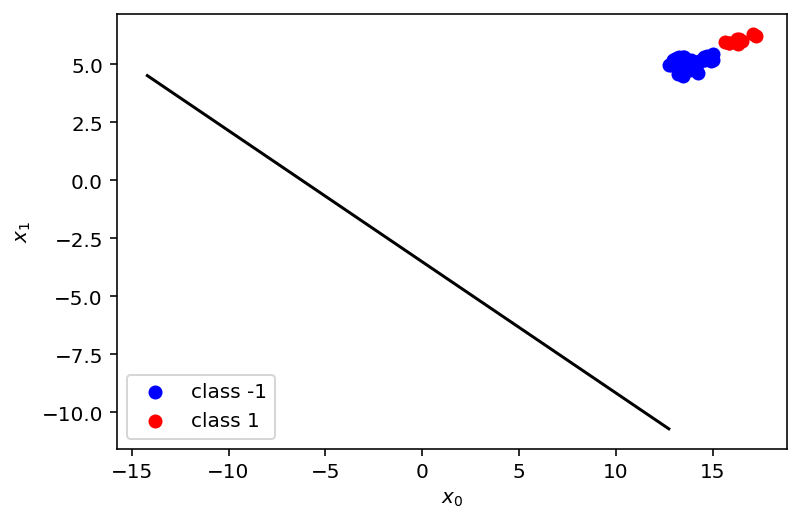

Training error: 0.7857142857142857




Test error: 0.6369047619047619
C = 1
Decision boundary: 0.004x_0+0.054x_1+-1.333=0
[296.5268  269.75903]
269.75903 6.321


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


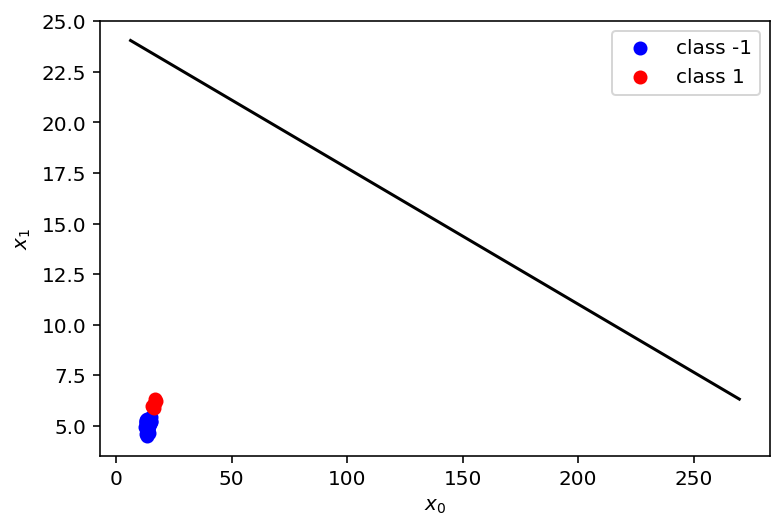

Training error: 0.7857142857142857




Test error: 0.6369047619047619
C = 10
Decision boundary: 0.131x_0+1.500x_1+-10.628=0
[29.462315  8.775261]
12.73 6.321


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


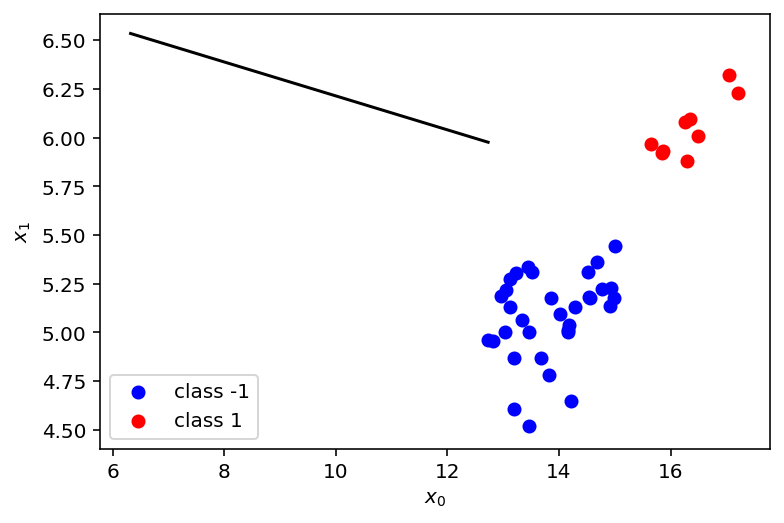

Training error: 1.0




Test error: 0.6369047619047619
C = 100
Decision boundary: 0.234x_0+1.659x_1+-12.898=0
[23.090012 10.315956]
12.73 6.321


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


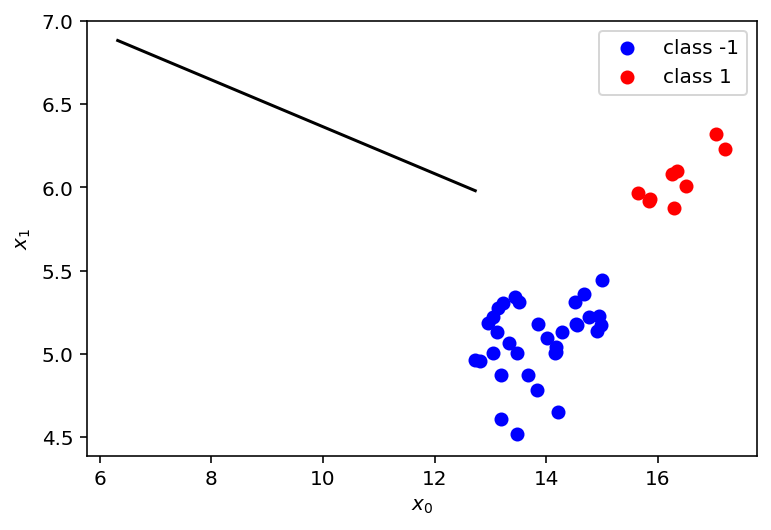

Training error: 1.0




Test error: 0.6369047619047619
C = 1000
Decision boundary: 0.188x_0+1.857x_1+-13.267=0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[25.88395   8.112934]
12.73 6.321


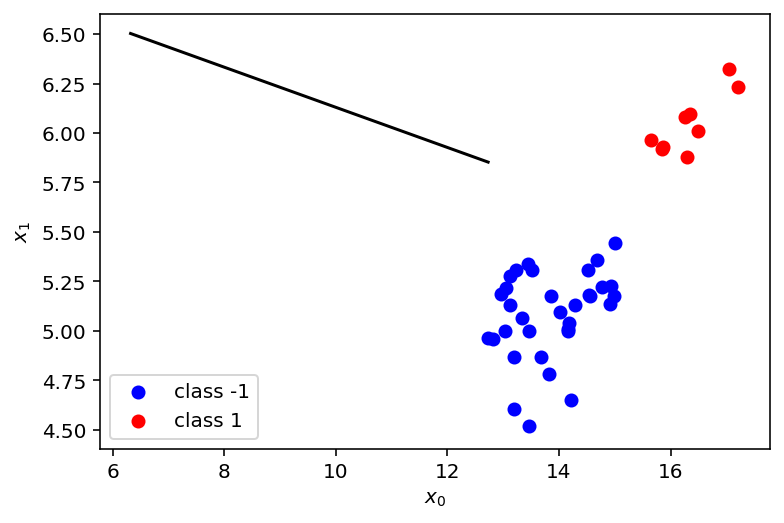

Training error: 1.0




Test error: 0.6369047619047619


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


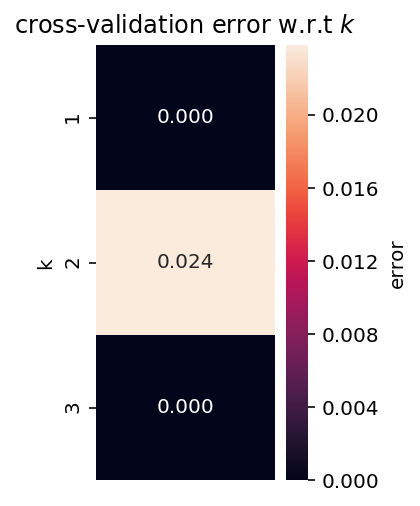

k=1


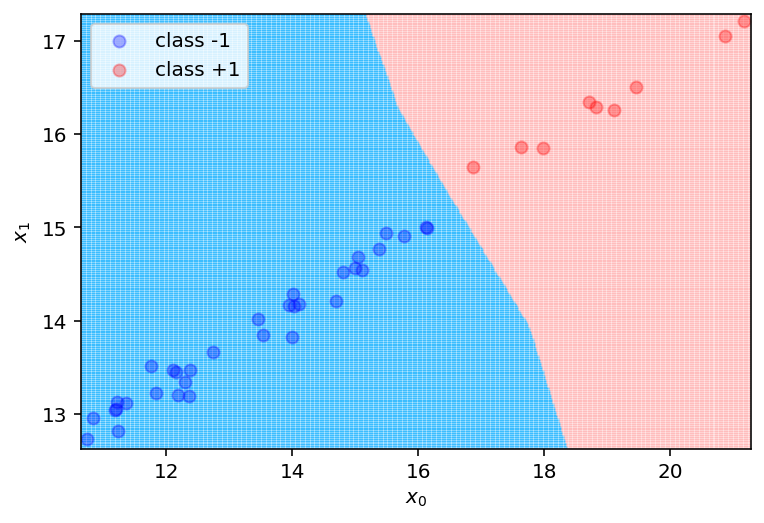

Validation error: 0.0

k=2


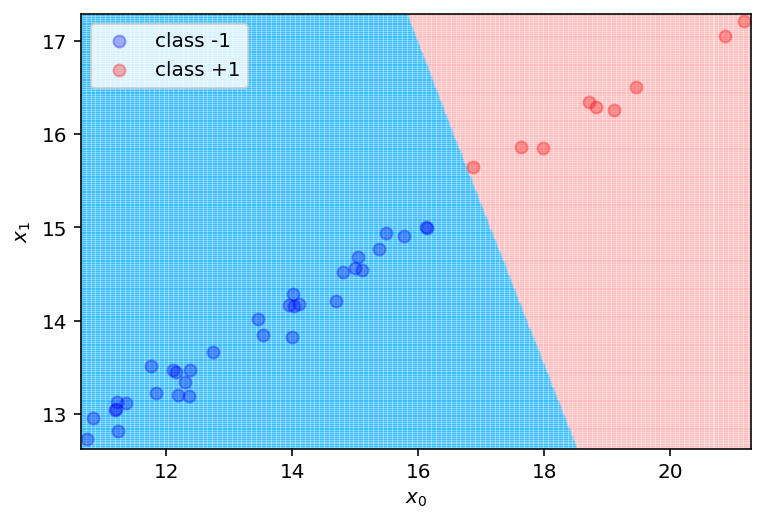

Validation error: 0.0

k=3


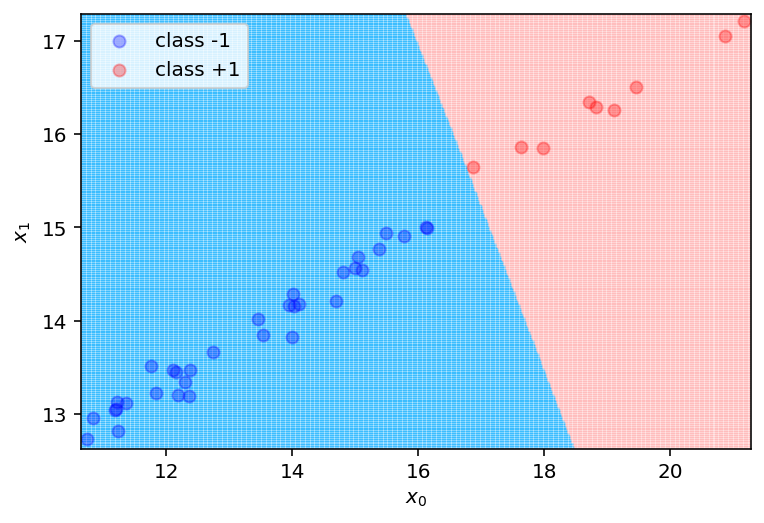

Validation error: 0.0

Best k=1


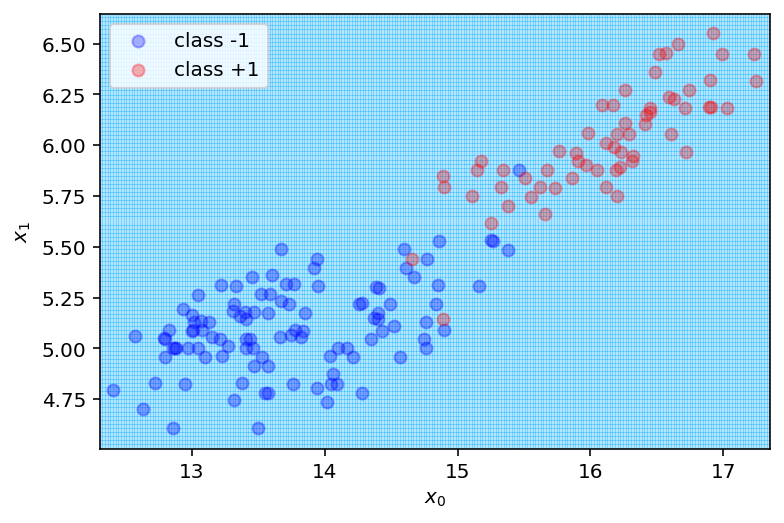

Test error: 0.3630952380952381


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


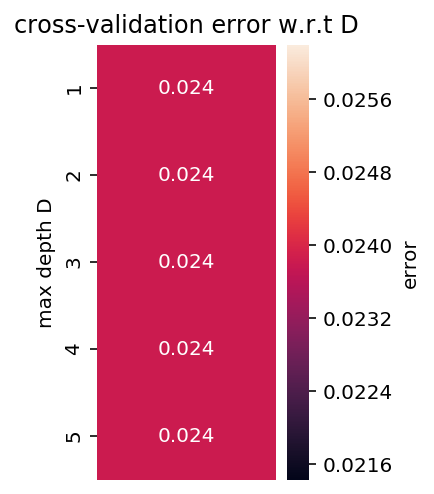

Best max depth D: {'max_depth': 1}
Test error: 0.0


In [24]:
# load & shuffle data
X_and_Y = np.loadtxt('seeds.csv', delimiter='\t').astype(np.float32) # Load data from file.

np.random.seed(1)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==1] = -1   
Y_shuffled[Y_shuffled==3] = -1
Y_shuffled[Y_shuffled==2] = 1  

# split data
X_train_20 = X_shuffled[:42][:,[1,6]] # Shape: (42,2)

Y_train_20 = Y_shuffled[:42]          # Shape: (42,)

X_test_80 = X_shuffled[42:][:,[1,6]]  # Shape: (168,2)
Y_test_80 = Y_shuffled[42:]          # Shape: (42,)

# Print info 
print(X_train_20.shape)
print(Y_train_20.shape)
print(X_test_80.shape)
print(Y_test_80.shape)

# apply classifier #1
linear_svm(X_train_20, Y_train_20, X_test_80, Y_test_80)

# apply classifier #2
X_train_20 = X_shuffled[:42]         # Shape: (168,2)
Y_train_20 = Y_shuffled[:42]         # Shape: (168,)

knn_gridsearch(X_train_20, Y_train_20)
opt_vals = knn_2(X_train_20, Y_train_20)

opt_k = opt_vals[0]
opt_knn_classifier = opt_vals[1]
print("Best k={}".format(opt_k))

test_error = calc_error2(X_test_80, Y_test_80, opt_knn_classifier)
vis2(X_test_80, Y_test_80, opt_knn_classifier)
print("Test error: {}".format(test_error))

# apply classifier #3
decision_tree(X_train_20, Y_train_20)



### Split 1 / Trial 2 / Classifier #1-3

(42, 2)
(42,)
(168, 2)
(168,)
C = 0.1
Decision boundary: -0.040x_0+-0.049x_1+-0.203=0
[-10.5980625 -12.6064205]
12.82 -10.5980625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


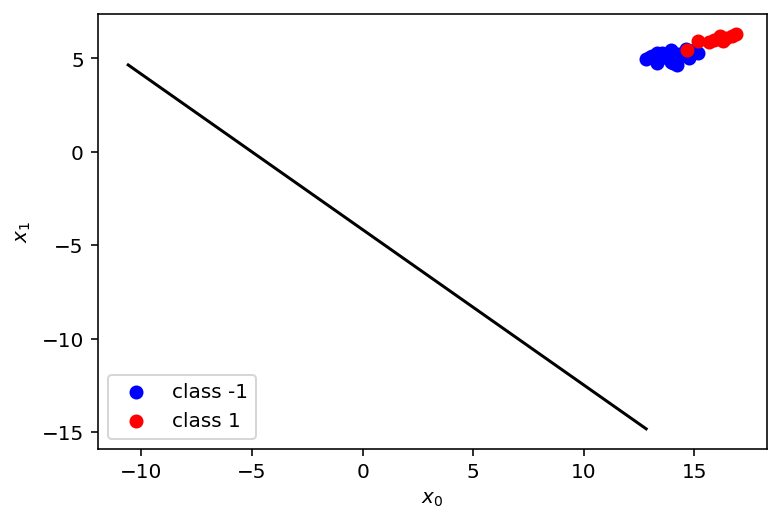

Training error: 0.7619047619047619




Test error: 0.6428571428571429
C = 1
Decision boundary: 0.011x_0+0.053x_1+-1.426=0
[103.81016  95.9388 ]
95.9388 6.32


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


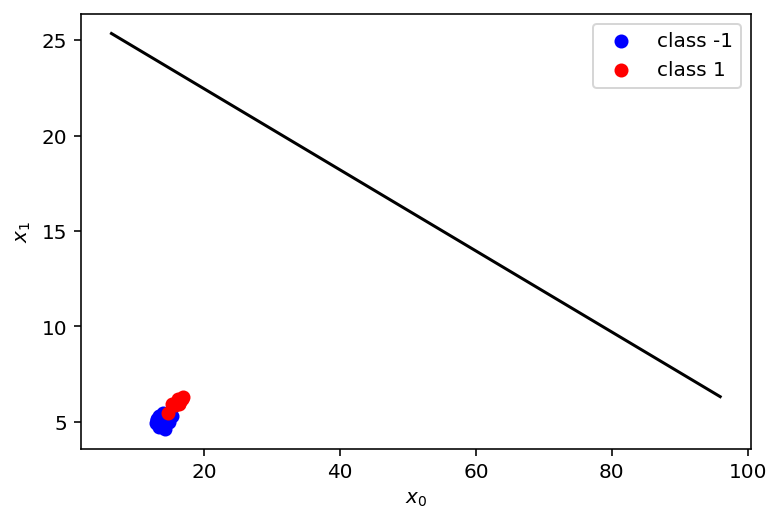

Training error: 0.7619047619047619




Test error: 0.6428571428571429
C = 10
Decision boundary: 0.214x_0+1.270x_1+-10.638=0
[22.152119 12.219971]
12.82 6.32


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


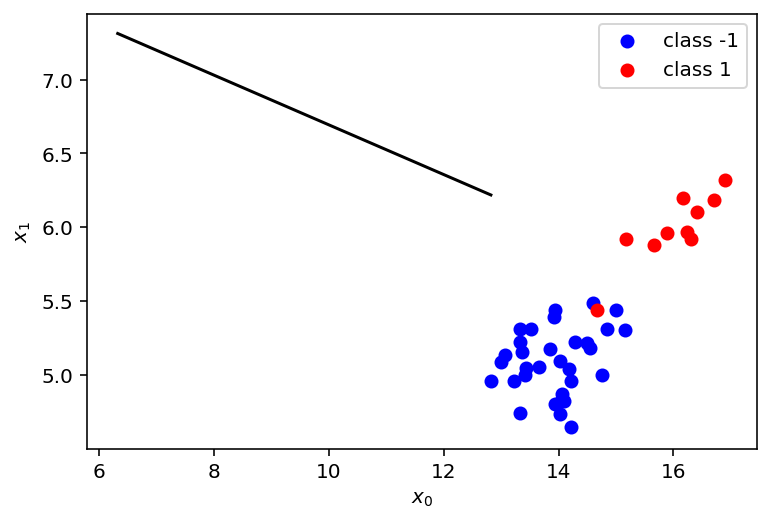

Training error: 0.9761904761904762




Test error: 0.6428571428571429
C = 100
Decision boundary: 0.249x_0+1.577x_1+-12.713=0
[21.587313 11.02108 ]
12.82 6.32


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


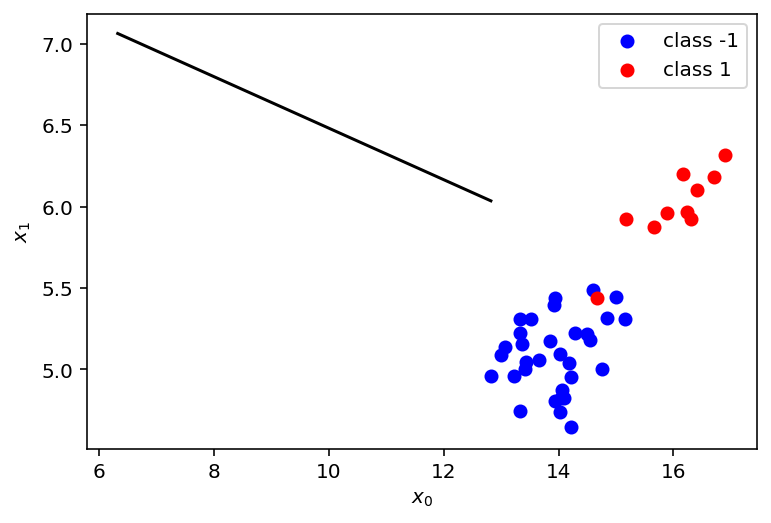

Training error: 0.9761904761904762




Test error: 0.6428571428571429
C = 1000
Decision boundary: 0.249x_0+1.664x_1+-12.920=0
[20.80833   9.654072]
12.82 6.32


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


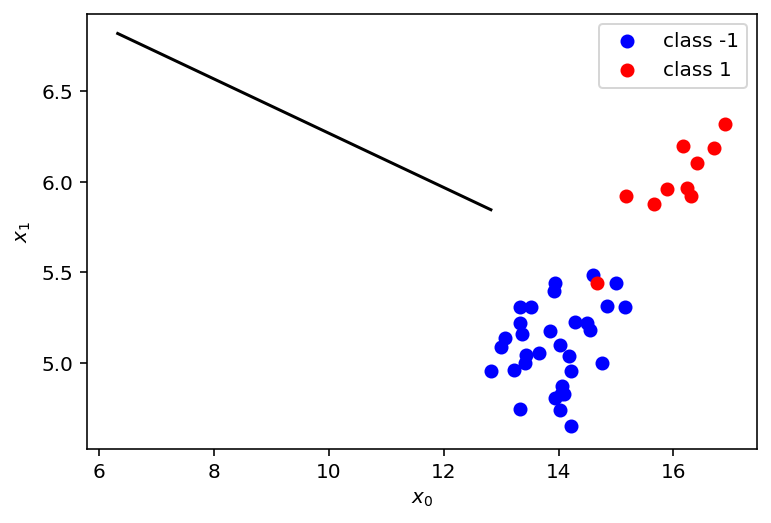

Training error: 0.9761904761904762




Test error: 0.6428571428571429


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


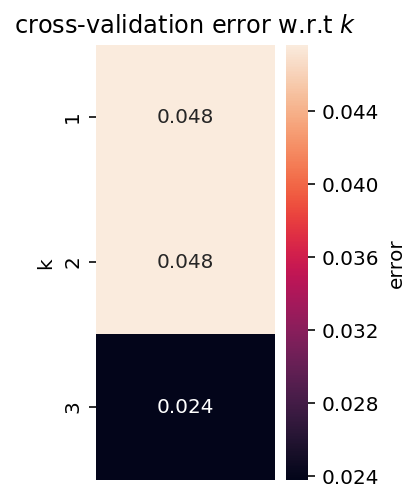

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


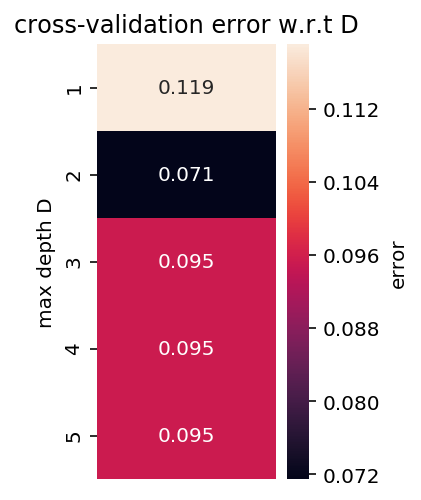

Best max depth D: {'max_depth': 2}
Test error: 0.023809523809523836


In [30]:
# load & shuffle data
X_and_Y = np.loadtxt('seeds.csv', delimiter='\t').astype(np.float32) # Load data from file.

np.random.seed(2)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==1] = -1   
Y_shuffled[Y_shuffled==3] = -1
Y_shuffled[Y_shuffled==2] = 1  

# split data
X_train_20 = X_shuffled[:42][:,[1,6]] # Shape: (42,2)

Y_train_20 = Y_shuffled[:42]          # Shape: (42,)

X_test_80 = X_shuffled[42:][:,[1,6]]  # Shape: (168,2)
Y_test_80 = Y_shuffled[42:]          # Shape: (42,)

# Print info 
print(X_train_20.shape)
print(Y_train_20.shape)
print(X_test_80.shape)
print(Y_test_80.shape)

# apply classifier #1
linear_svm(X_train_20, Y_train_20, X_test_80, Y_test_80)

# apply classifier #2
X_train_20 = X_shuffled[:42]         # Shape: (168,2)
Y_train_20 = Y_shuffled[:42]         # Shape: (168,)

knn_gridsearch(X_train_20, Y_train_20)

# apply classifier #3
decision_tree(X_train_20, Y_train_20)



### Split 1 / Trial 3 / Classifier #1-3

(42, 2)
(42,)
(168, 2)
(168,)
C = 0.1
Decision boundary: -0.022x_0+-0.074x_1+-0.303=0
[-29.369747 -35.20952 ]
12.63 -29.369747


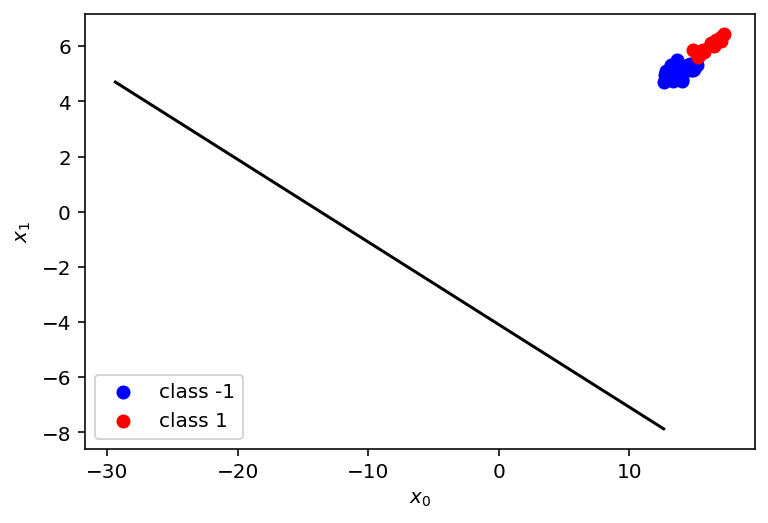

Training error: 0.6666666666666666




Test error: 0.6666666666666666
C = 1
Decision boundary: -0.015x_0+0.256x_1+-2.106=0
[-59.974632 -30.21148 ]
12.63 -30.21148


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


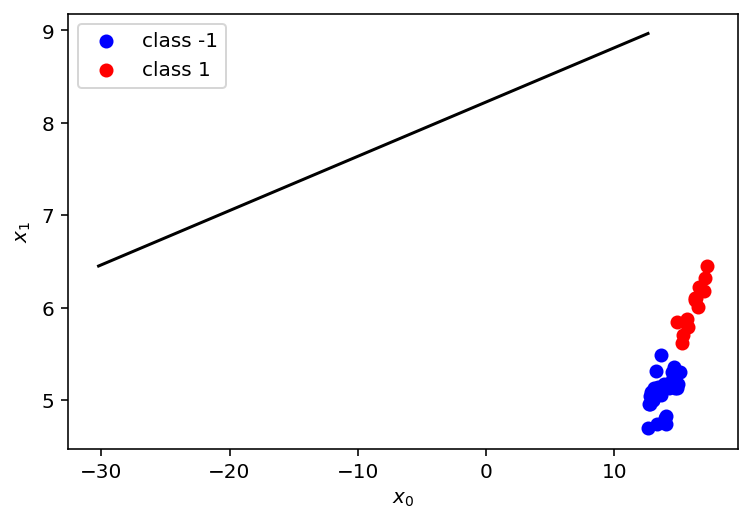

Training error: 0.6666666666666666




Test error: 0.6666666666666666
C = 10
Decision boundary: -0.057x_0+2.154x_1+-11.209=0
[-18.879807  46.94673 ]
12.63 6.451


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


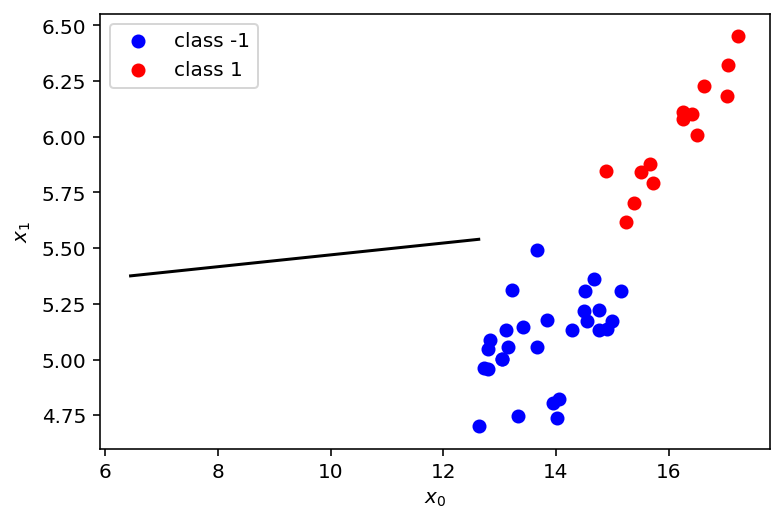

Training error: 1.0




Test error: 0.6666666666666666
C = 100
Decision boundary: 0.079x_0+2.232x_1+-13.923=0
[43.191345  -5.9546814]
12.63 6.451


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


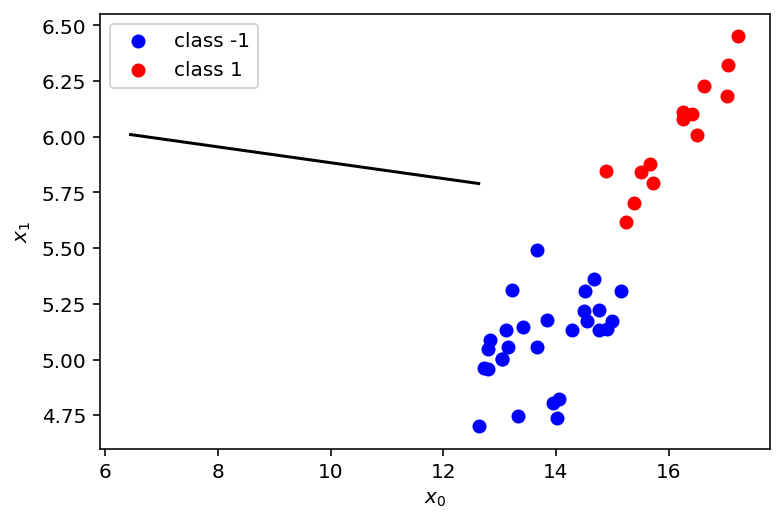

Training error: 0.9761904761904762




Test error: 0.6666666666666666
C = 1000
Decision boundary: 0.073x_0+2.293x_1+-13.957=0
[ 43.62358  -11.493805]
12.63 6.451


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


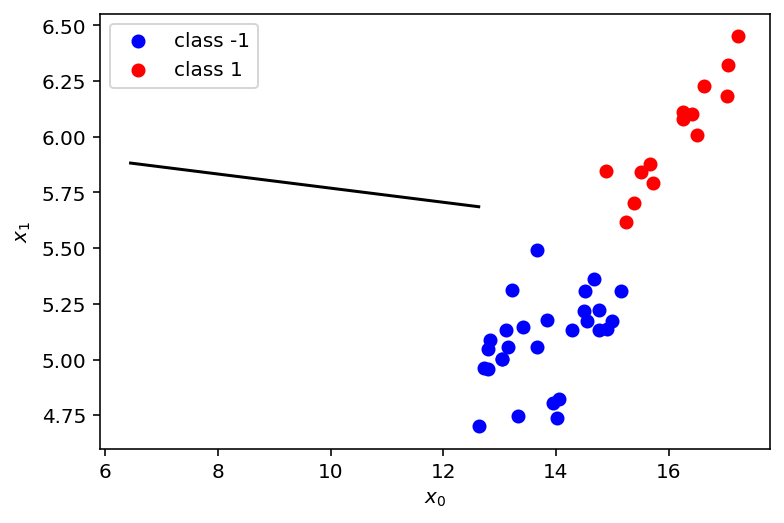

Training error: 1.0




Test error: 0.6666666666666666


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


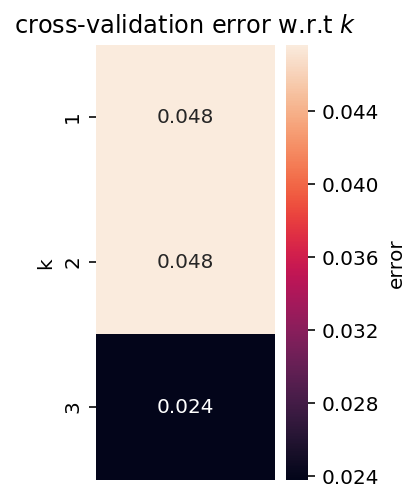

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


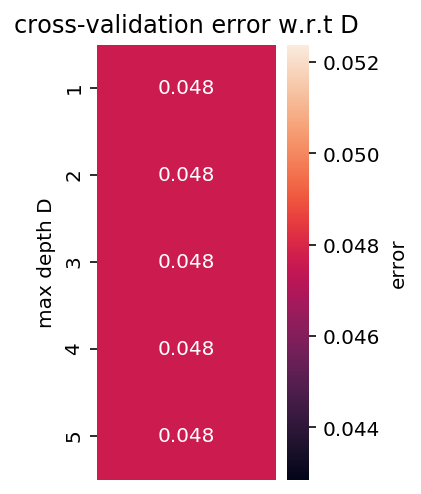

Best max depth D: {'max_depth': 1}
Test error: 0.0


In [31]:
# load & shuffle data
X_and_Y = np.loadtxt('seeds.csv', delimiter='\t').astype(np.float32) # Load data from file.

np.random.seed(3)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==1] = -1   
Y_shuffled[Y_shuffled==3] = -1
Y_shuffled[Y_shuffled==2] = 1  

# split data
X_train_20 = X_shuffled[:42][:,[1,6]] # Shape: (42,2)

Y_train_20 = Y_shuffled[:42]          # Shape: (42,)

X_test_80 = X_shuffled[42:][:,[1,6]]  # Shape: (168,2)
Y_test_80 = Y_shuffled[42:]          # Shape: (42,)

# Print info 
print(X_train_20.shape)
print(Y_train_20.shape)
print(X_test_80.shape)
print(Y_test_80.shape)

# apply classifier #1
linear_svm(X_train_20, Y_train_20, X_test_80, Y_test_80)

# apply classifier #2
X_train_20 = X_shuffled[:42]         # Shape: (168,2)
Y_train_20 = Y_shuffled[:42]         # Shape: (168,)

knn_gridsearch(X_train_20, Y_train_20)


# apply classifier #3
decision_tree(X_train_20, Y_train_20)



# -------------------------------------------------------------

## SPLIT 2: 80% TRAIN / 20% TEST

### Split 2 / Trial 1 / Classifier #1-3

(168, 2)
(168,)
(42, 2)
(42,)
C = 0.1
Decision boundary: 0.000x_0+0.000x_1+-1.000=0
[86625.6  86615.77]
86615.77 6.55


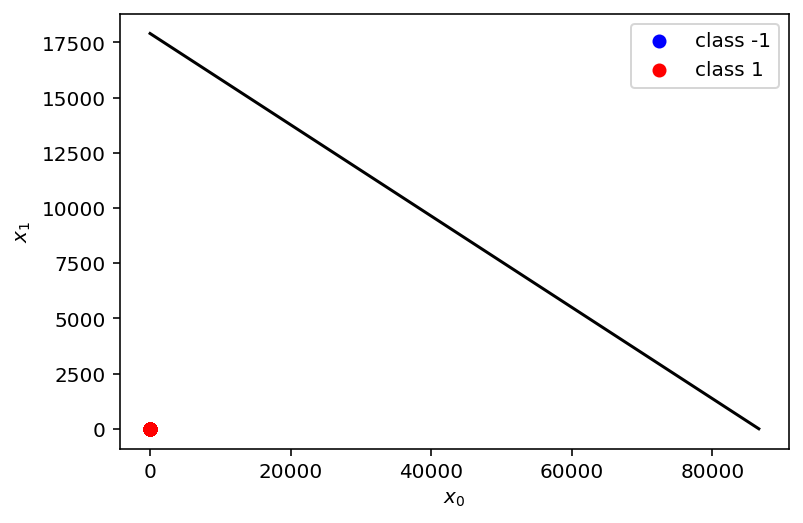

Training error: 0.6726190476190477




Test error: 0.6428571428571429
C = 1
Decision boundary: 0.182x_0+0.949x_1+-8.264=0
[21.790197 11.225327]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


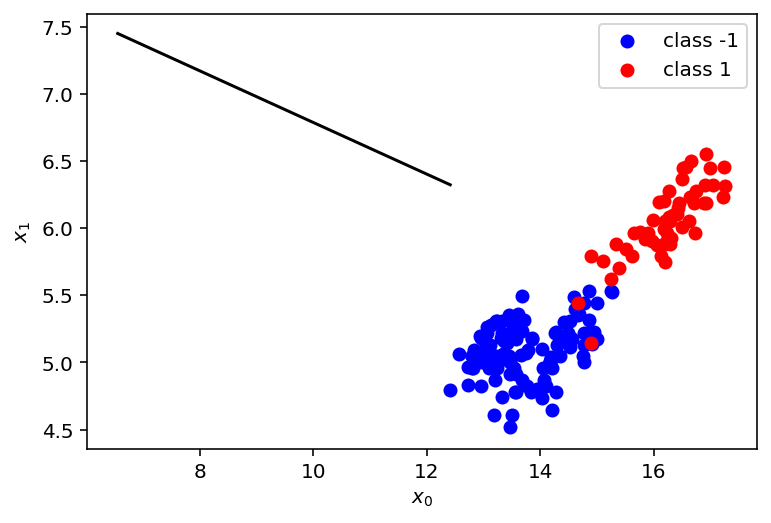

Training error: 0.9642857142857143




Test error: 0.6428571428571429
C = 10
Decision boundary: 0.234x_0+2.245x_1+-16.013=0
[25.111488  5.595619]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


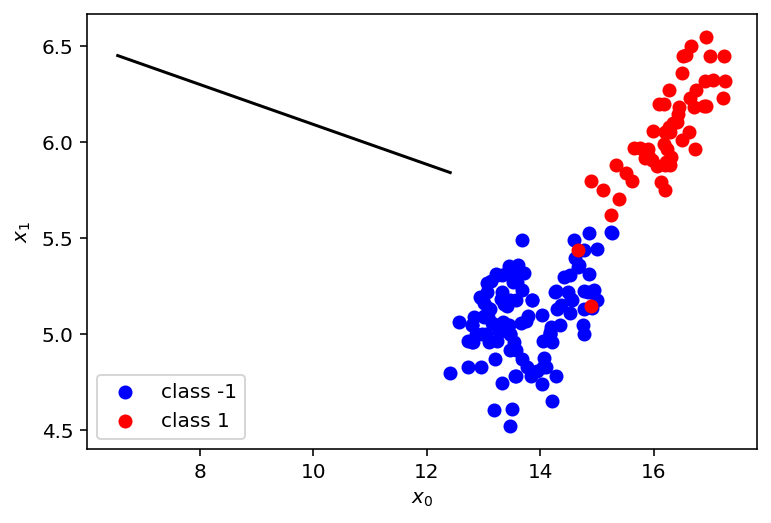

Training error: 0.9880952380952381




Test error: 0.6428571428571429
C = 100
Decision boundary: 0.371x_0+1.993x_1+-16.703=0
[20.716063  9.816147]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


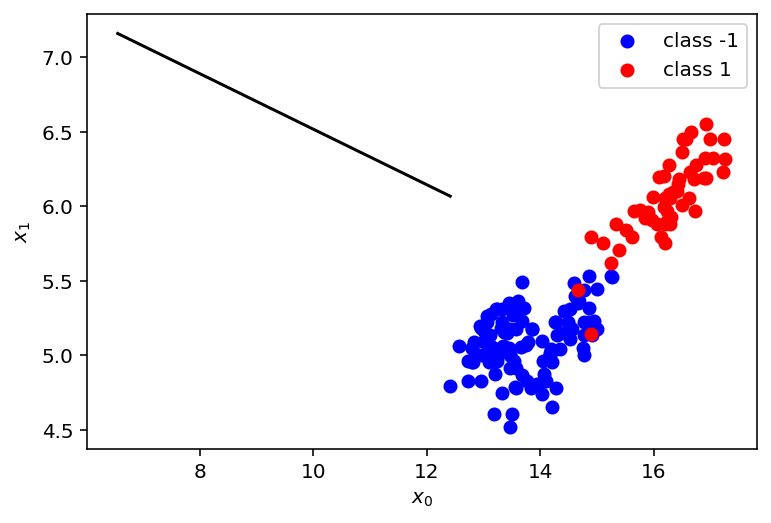

Training error: 0.9880952380952381




Test error: 0.6428571428571429
C = 1000
Decision boundary: 0.380x_0+2.049x_1+-16.534=0
[19.127314  8.190186]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


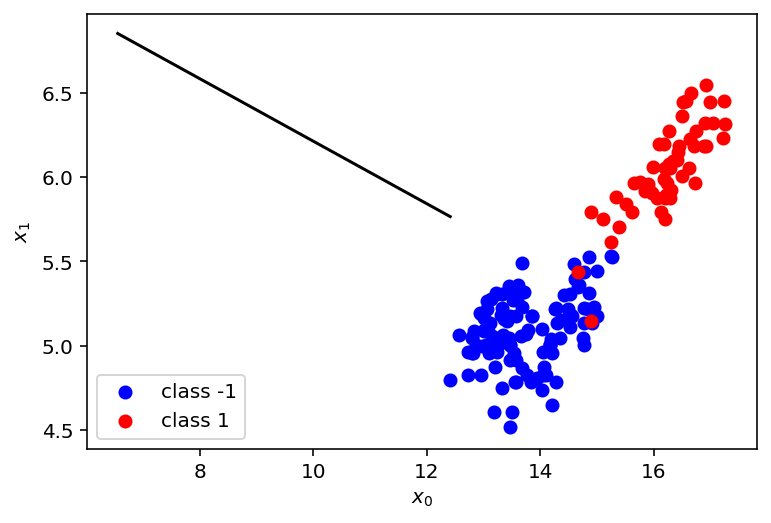

Training error: 0.9345238095238095




Test error: 0.6428571428571429


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


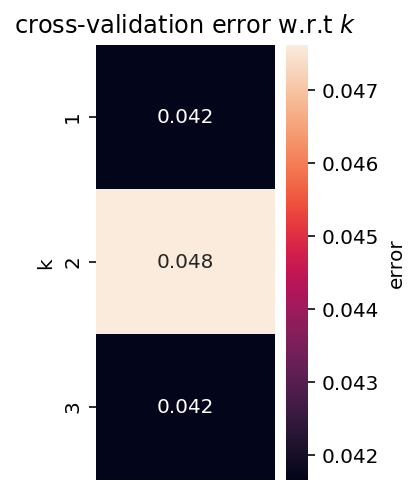

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


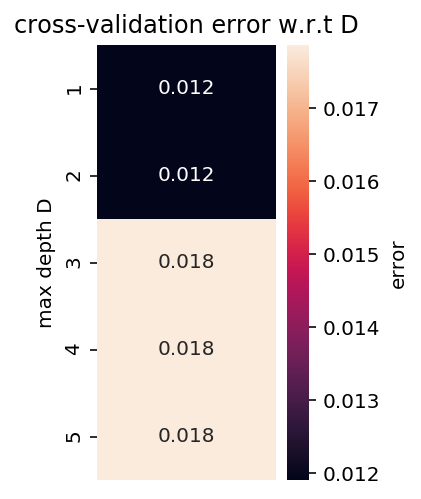

Best max depth D: {'max_depth': 1}
Test error: 0.011904761904761862


In [26]:
# load & shuffle data
X_and_Y = np.loadtxt('seeds.csv', delimiter='\t').astype(np.float32) # Load data from file.

np.random.seed(1)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==1] = -1   
Y_shuffled[Y_shuffled==3] = -1
Y_shuffled[Y_shuffled==2] = 1  

# split data
X_train_80 = X_shuffled[:168][:,[1,6]] # Shape: (168,2)
Y_train_80 = Y_shuffled[:168]          # Shape: (168,)

X_test_20 = X_shuffled[168:][:,[1,6]]  # Shape: (42,2)
Y_test_20 = Y_shuffled[168:]           # Shape: (42,)

# Print info 
print(X_train_80.shape)
print(Y_train_80.shape)
print(X_test_20.shape)
print(Y_test_20.shape)

# apply classifier #1
linear_svm(X_train_80, Y_train_80, X_test_20, Y_test_20)


# apply classifier #2
X_train_80 = X_shuffled[:168]         # Shape: (168,2)
Y_train_80 = Y_shuffled[:168]         # Shape: (168,)

knn_gridsearch(X_train_80, Y_train_80)


# apply classifier #3
decision_tree(X_train_80, Y_train_80)


### Split 2 / Trial 2 / Classifier #1-3

(168, 2)
(168,)
(42, 2)
(42,)
C = 0.1
Decision boundary: 0.000x_0+0.000x_1+-1.000=0
[97871.87  97863.305]
97863.305 6.55


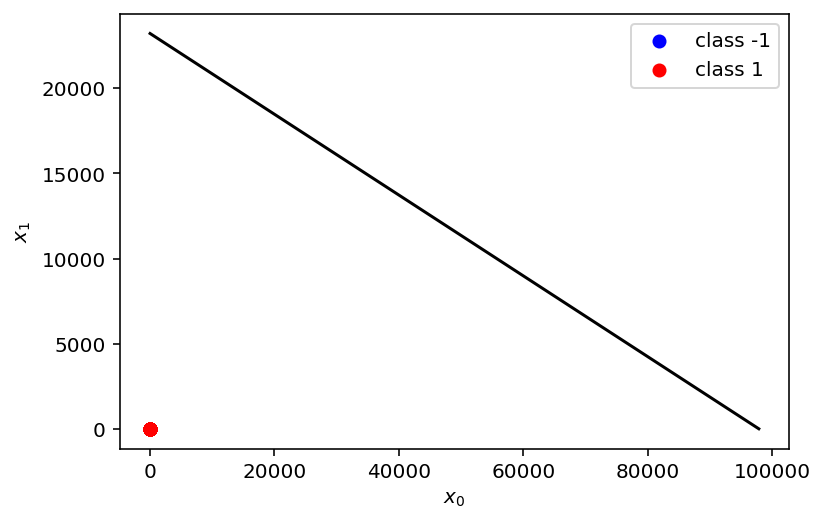

Training error: 0.6607142857142857




Test error: 0.6904761904761905
C = 1
Decision boundary: 0.233x_0+0.819x_1+-8.269=0
[19.587723 12.4552  ]
12.4552 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


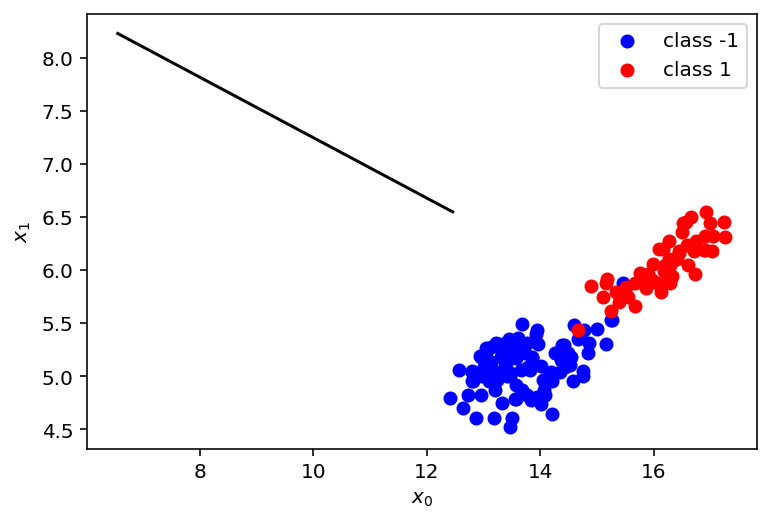

Training error: 0.9642857142857143




Test error: 0.6904761904761905
C = 10
Decision boundary: 0.247x_0+2.142x_1+-15.821=0
[24.814812   7.2290306]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


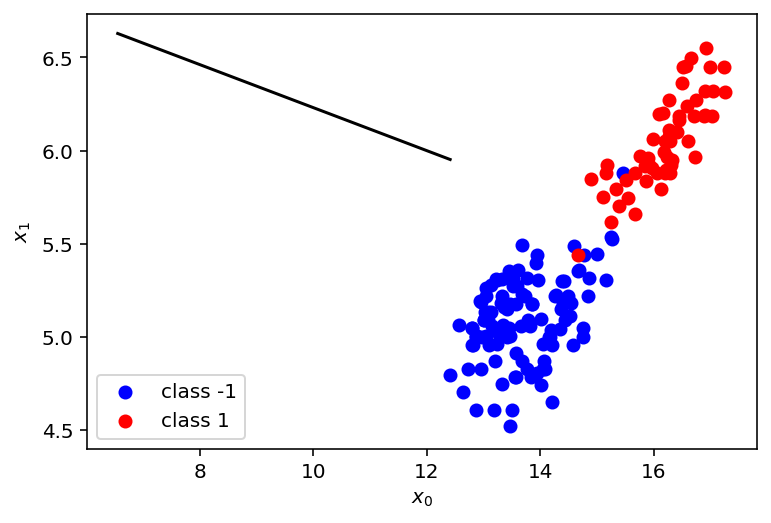

Training error: 0.9821428571428571




Test error: 0.6904761904761905
C = 100
Decision boundary: 0.184x_0+2.641x_1+-17.517=0
[30.405884   1.1915207]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


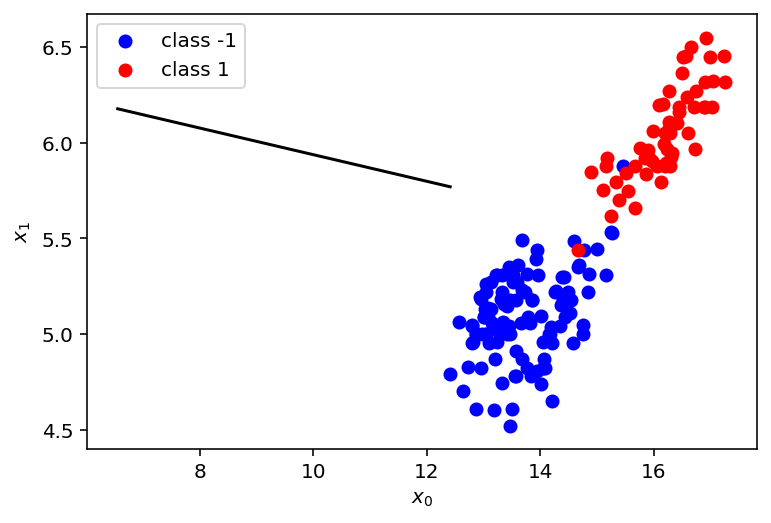

Training error: 0.9880952380952381




Test error: 0.6904761904761905
C = 1000
Decision boundary: 0.203x_0+2.739x_1+-18.296=0
[29.088242   1.7372208]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


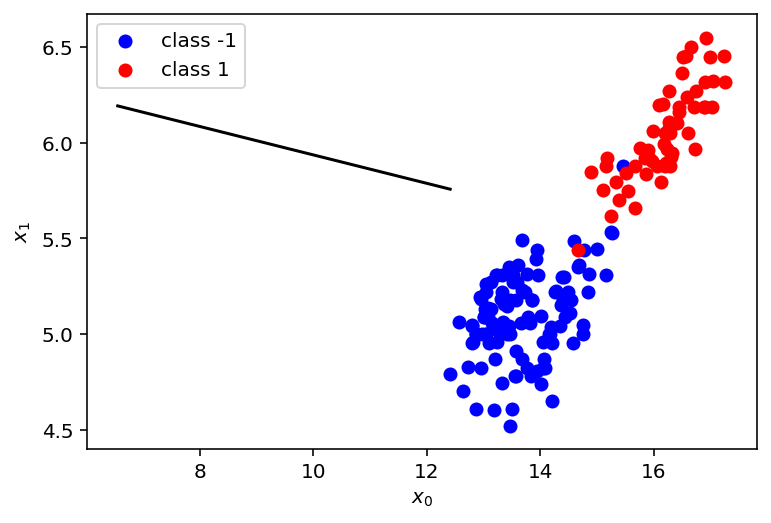

Training error: 0.9880952380952381




Test error: 0.6904761904761905


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


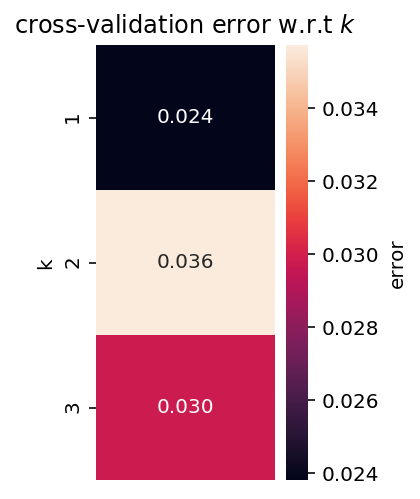

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


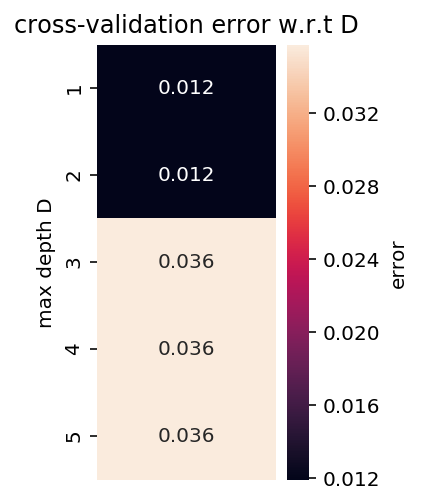

Best max depth D: {'max_depth': 1}
Test error: 0.011904761904761862


In [27]:
# load & shuffle data
X_and_Y = np.loadtxt('seeds.csv', delimiter='\t').astype(np.float32) # Load data from file.

np.random.seed(2)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==1] = -1   
Y_shuffled[Y_shuffled==3] = -1
Y_shuffled[Y_shuffled==2] = 1  

# split data
X_train_80 = X_shuffled[:168][:,[1,6]] # Shape: (168,2)
Y_train_80 = Y_shuffled[:168]          # Shape: (168,)

X_test_20 = X_shuffled[168:][:,[1,6]]  # Shape: (42,2)
Y_test_20 = Y_shuffled[168:]           # Shape: (42,)

# Print info 
print(X_train_80.shape)
print(Y_train_80.shape)
print(X_test_20.shape)
print(Y_test_20.shape)

# apply classifier #1
linear_svm(X_train_80, Y_train_80, X_test_20, Y_test_20)

# apply classifier #2
X_train_80 = X_shuffled[:168]         # Shape: (168,2)
Y_train_80 = Y_shuffled[:168]         # Shape: (168,)

knn_gridsearch(X_train_80, Y_train_80)


# apply classifier #3
decision_tree(X_train_80, Y_train_80)


### Split 2 / Trial 3 / Classifier #1-3

(168, 2)
(168,)
(42, 2)
(42,)
C = 0.1
Decision boundary: 0.000x_0+0.000x_1+-1.000=0
[123327.16 123314.04]
123314.04 6.55


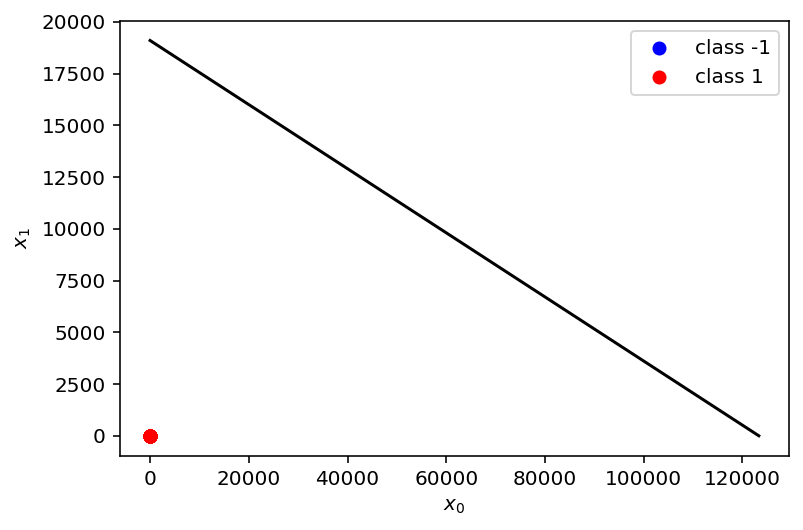

Training error: 0.6666666666666666




Test error: 0.6666666666666666
C = 1
Decision boundary: 0.095x_0+1.126x_1+-7.982=0
[30.356102  6.341194]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


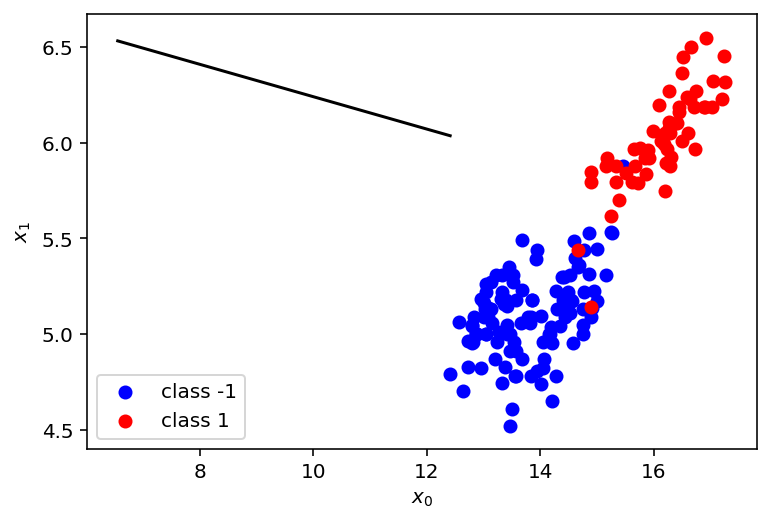

Training error: 0.9642857142857143




Test error: 0.6666666666666666
C = 10
Decision boundary: 0.172x_0+2.304x_1+-15.476=0
[29.377743  2.228119]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


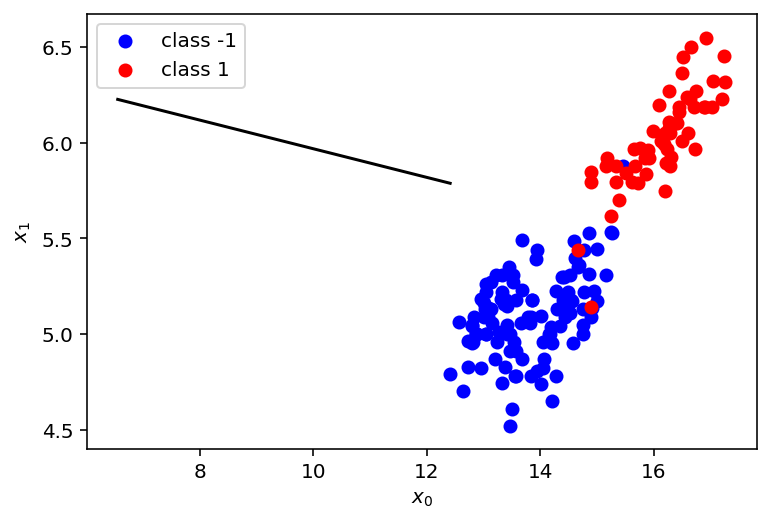

Training error: 0.9821428571428571




Test error: 0.6666666666666666
C = 100
Decision boundary: 0.277x_0+2.332x_1+-17.243=0
[24.245808  7.116745]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


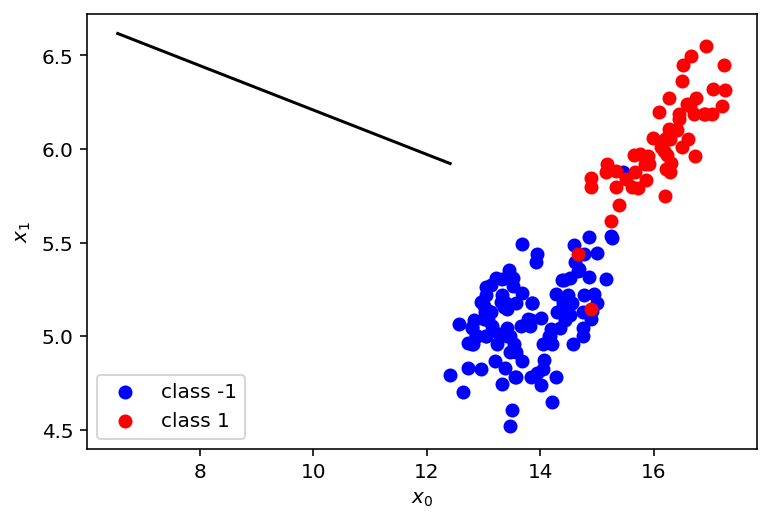

Training error: 0.9821428571428571




Test error: 0.6666666666666666
C = 1000
Decision boundary: 0.411x_0+2.135x_1+-16.644=0
[17.005087  6.460621]
12.41 6.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


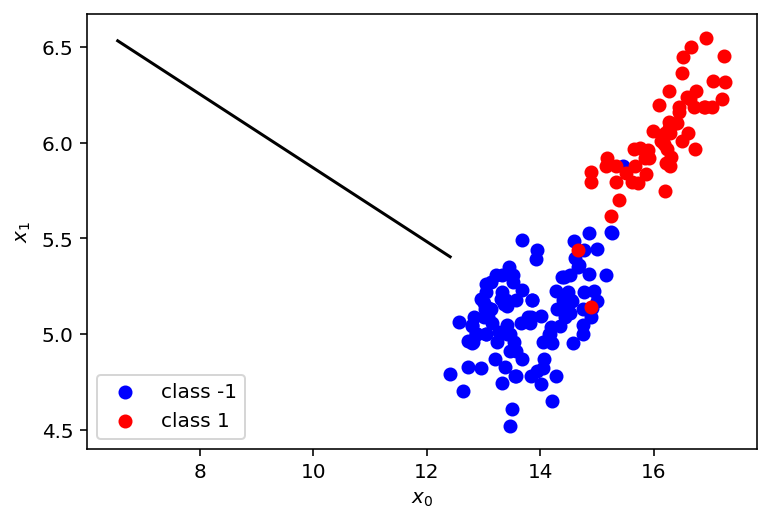

Training error: 0.7261904761904762




Test error: 0.6666666666666666


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


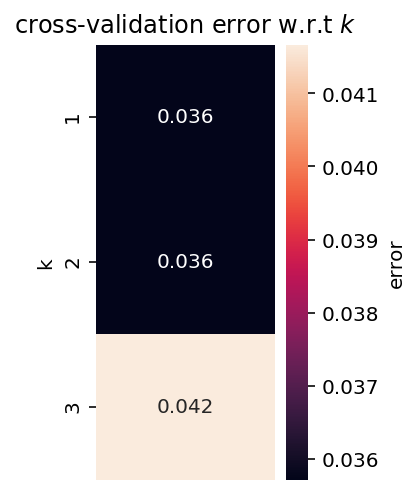

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


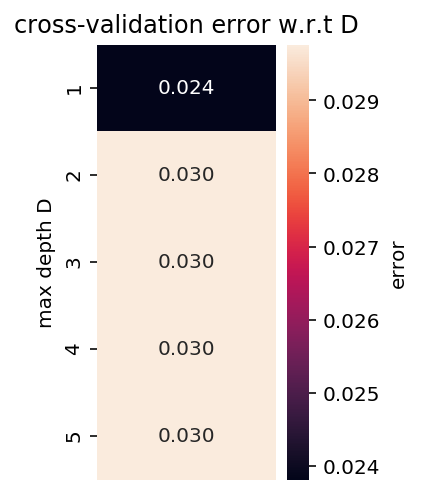

Best max depth D: {'max_depth': 1}
Test error: 0.017857142857142905


In [28]:
# load & shuffle data
X_and_Y = np.loadtxt('seeds.csv', delimiter='\t').astype(np.float32) # Load data from file.

np.random.seed(3)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==1] = -1   
Y_shuffled[Y_shuffled==3] = -1
Y_shuffled[Y_shuffled==2] = 1  

# split data
X_train_80 = X_shuffled[:168][:,[1,6]] # Shape: (168,2)
Y_train_80 = Y_shuffled[:168]          # Shape: (168,)

X_test_20 = X_shuffled[168:][:,[1,6]]  # Shape: (42,2)
Y_test_20 = Y_shuffled[168:]           # Shape: (42,)

# Print info 
print(X_train_80.shape)
print(Y_train_80.shape)
print(X_test_20.shape)
print(Y_test_20.shape)

# apply classifier #1
linear_svm(X_train_80, Y_train_80, X_test_20, Y_test_20)

# apply classifier #2
X_train_80 = X_shuffled[:168]         # Shape: (168,2)
Y_train_80 = Y_shuffled[:168]         # Shape: (168,)

knn_gridsearch(X_train_80, Y_train_80)


# apply classifier #3
decision_tree(X_train_80, Y_train_80)
